In [6]:
# NOTE: change the root_dir path to your working dir path

import sys
root_dir = '/home/lpandey/Baby_Research/'
sys.path.append(root_dir)

import os
import pandas as pd
import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.transforms as T
import matplotlib
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from models.vit_contrastive import VisionTransformer, Backbone, LitClassifier, ViTConfigExtended, ViTConfig, configuration
from models.archs.resnet_2b import resnet_2blocks
from models.simclr import SimCLR
plt.rcParams["figure.figsize"] = (10,10)

In [7]:
# SELECT AND LOAD MODEL
def init_model(model, model_path=None):
    if model == 'pixels':
        model = nn.Flatten()
    elif model == 'simclr':
        model = SimCLR.load_from_checkpoint(model_path)
    elif model == 'supervised':
        model = resnet18(pretrained=True)
        model.fc = nn.Identity()
    elif model == 'untrained_r18_2b':
        model = resnet_2blocks(pretrained=False)
        model.fc = nn.Identity()
        print("Model selected - untrained resnet 18 : 2 blocks")
    elif model == 'vit':
        model = LitClassifier.load_from_checkpoint(model_path).backbone
        model.fc = nn.Identity()
    elif model == 'untrained_vit':
        configuration = ViTConfigExtended()
        configuration.num_attention_heads = configuration.num_hidden_layers = 9
        # print configuration parameters of ViT
        print('[INFO]  Image_size  :: ', configuration.image_size)
        print('[INFO]  Patch_size  :: ', configuration.patch_size)
        print('[INFO]  Num_classes  :: ', configuration.num_classes)
        print('[INFO]  Hidden_size  :: ', configuration.hidden_size)
        print('[INFO]  Intermediate_size  :: ', configuration.intermediate_size)
        print('[INFO]  Num_hidden_layers  :: ', configuration.num_hidden_layers)
        print('[INFO]  Num_attention_heads  :: ', configuration.num_attention_heads)
        
        # pass the configuration parameters to get backbone
        backbone = Backbone('vit', configuration)
        model = LitClassifier(backbone).backbone
        model.fc = nn.Identity()
    return model

In [10]:
# CUSTOM COLORS
# TOFIX: modify this code using a dict

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the color you want to use
my_color = 'red'
my_color2 = 'blue'
my_color3 = 'black'
my_color4 = 'green'
my_color5 = 'grey'
my_color6 = 'seagreen'
my_color7 = 'orange'
my_color8 = 'pink'
my_color9 = 'yellow'
my_color10 = 'brown'
my_color11 = 'violet'
my_color12 = 'teal'
my_color13 = 'purple'

# Create a custom colormap with a single color
cmap_self = mcolors.LinearSegmentedColormap.from_list("", [my_color, my_color])
cmap_self2 = mcolors.LinearSegmentedColormap.from_list("", [my_color2, my_color2])
cmap_self3 = mcolors.LinearSegmentedColormap.from_list("", [my_color3, my_color3])
cmap_self4 = mcolors.LinearSegmentedColormap.from_list("", [my_color4, my_color4])
cmap_self5 = mcolors.LinearSegmentedColormap.from_list("", [my_color5, my_color5])
cmap_self6 = mcolors.LinearSegmentedColormap.from_list("", [my_color6, my_color6])
cmap_self7 = mcolors.LinearSegmentedColormap.from_list("", [my_color7, my_color7])
cmap_self8 = mcolors.LinearSegmentedColormap.from_list("", [my_color8, my_color8])
cmap_self9 = mcolors.LinearSegmentedColormap.from_list("", [my_color9, my_color9])
cmap_self10 = mcolors.LinearSegmentedColormap.from_list("", [my_color10, my_color10])
cmap_self11 = mcolors.LinearSegmentedColormap.from_list("", [my_color11, my_color11])
cmap_self12 = mcolors.LinearSegmentedColormap.from_list("", [my_color12, my_color12])
cmap_self13 = mcolors.LinearSegmentedColormap.from_list("", [my_color13, my_color13])


In [11]:
# separate dataloader for visual Binding data - 
dataset = ImageFolder('/data/lpandey/wood14_binding/testing/object1_separated/', transform=T.ToTensor())
data_loader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=16)

In [12]:
num_class = len(dataset.classes)
dataset.classes

['green_brokenWall',
 'green_circle',
 'green_cone',
 'green_triangle',
 'purple_brokenWall',
 'purple_circle',
 'purple_cone',
 'purple_triangle',
 'red_brokenWall',
 'red_circle',
 'red_cone',
 'red_triangle',
 'yellow_brokenWall',
 'yellow_circle',
 'yellow_cone',
 'yellow_triangle']

In [15]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from torchvision.transforms import ToPILImage

def plot_embedding_visualBinding(model, data_loader, title, seed, method='tSNE', plot_points=True, plot_images=False):
    features = []
    labels = []
    imgs = []

    # Extract features.
    model.eval()
    torch.manual_seed(seed)
    with torch.no_grad():
        for i, (img, label) in enumerate(data_loader):
            if i > 25:
                break
            output = model(img)
            features.append(output.cpu().numpy())
            labels.append(label.cpu().numpy())
            imgs.append(img) 

    X = np.concatenate(features, axis=0)
    y = np.concatenate(labels)
    z = np.concatenate(imgs)

    # Choose dimensionality reduction method.
    if method == 'PCA':
        dim_reduction =  PCA(n_components=2)
    elif method == 'tSNE':
        dim_reduction = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=6000, random_state=89)


    results = dim_reduction.fit_transform(X)
    fig, ax = plt.subplots()
    fig.set_dpi(100)

    if plot_points:

        for i in range(num_class):
            label = dataset.classes[i]

            # write the logic to plot feature clusters with different colors
            color = cmap_self3(10)
            ax.scatter(
                results[:, 0], results[:, 1],
                #label=label,
                alpha=0.5,
                color=color,
            )

    #ax.set_title(method)
    if title:
        ax.set_title(title, fontsize=60)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.legend(loc='upper left', shadow=False, scatterpoints=1, bbox_to_anchor=(1.05, 1))

    # Plot images.
    if plot_images:
        to_pil_image = ToPILImage()

        for x0, y0, im in zip(results[:,0], results[:,1], z):
            img_temp = torch.from_numpy(im)
            img = to_pil_image(img_temp)
            img.thumbnail((24,24))
            ab = AnnotationBbox(OffsetImage(img), (x0, y0), frameon=False)
            ax.add_artist(ab)

/home/lpandey/Baby_Research/baby_env/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(
/home/lpandey/Baby_Research/baby_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 464 samples in 0.000s...
[t-SNE] Computed neighbors for 464 samples in 0.189s...
[t-SNE] Computed conditional probabilities for sample 464 / 464
[t-SNE] Mean sigma: 1.065350
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.831886
[t-SNE] KL divergence after 6000 iterations: 0.294310


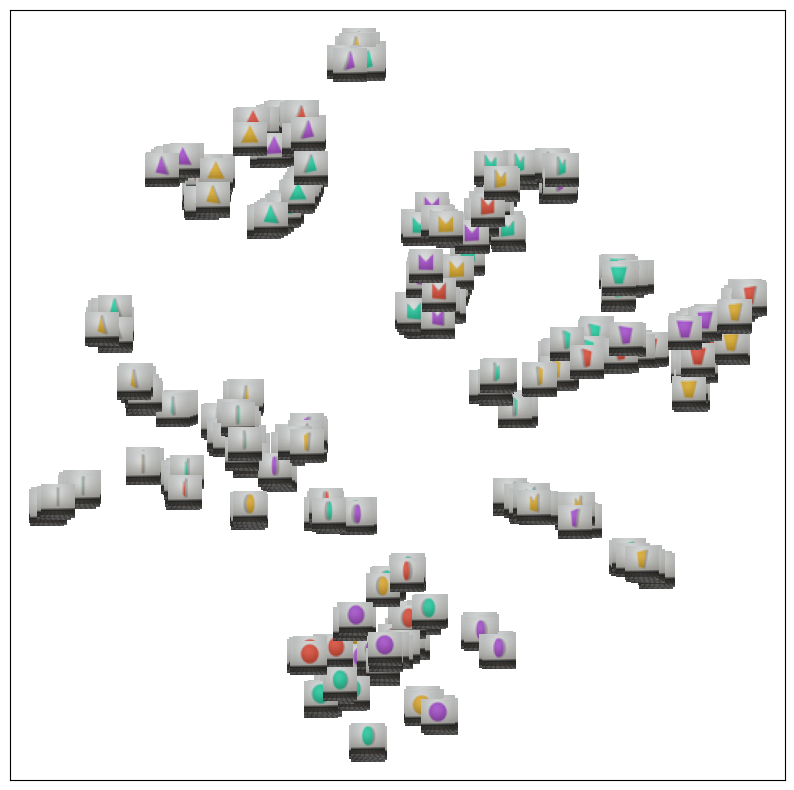

In [17]:
# DRIVER CODE

seed = 123
np.random.seed(seed)
model_path = '/data/lpandey/LOGS/VIT_Time/Eyeball_Project/PILOT_Experiments/UTAustinEgocentric/eyeball5_r20_1window_shuffle/80k/version_0/checkpoints/epoch=87-step=49544.ckpt'
model = init_model("vit", model_path)
plot_embedding_visualBinding(model, data_loader, "", seed, method='tSNE', plot_points=True, plot_images=True)